## Import Packages

cleaner but sometimes giving worse accuracy

In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.optim import lr_scheduler
from torch.utils.tensorboard import SummaryWriter
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.optim import lr_scheduler
from sklearn.metrics import precision_score, recall_score, f1_score
from tqdm import tqdm

## Set Random Seed

In [2]:
def set_seed(seed_value=24):
    random.seed(seed_value)       # Python random module
    np.random.seed(seed_value)    # Numpy module
    torch.manual_seed(seed_value) # Torch
    os.environ['PYTHONHASHSEED'] = str(seed_value)  # Environment variable

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)  # if using multi-GPU
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(24)  # Call the function with your chosen seed

if torch.backends.mps.is_available():
    torch.set_default_device('mps')

device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print("Using device: ", device)

Using device:  mps


## Data Management

### Define Transformations and Load Data

In [3]:
# Define transformations
transformations = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'val_test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485], std=[0.229])
    ])
}

generator = torch.Generator(device=device)

with torch.device(device):
    # Dataset paths
    # train_datapath = "/Users/dawsonhaddox/Documents/COSC 78/Final Project/Train Data"
    # validation_datapath = "/Users/dawsonhaddox/Documents/COSC 78/Final Project/Validation Data"
    # test_datapath = "/Users/dawsonhaddox/Documents/COSC 78/Final Project/Test Data"
    train_datapath = "/Users/dawsonhaddox/Documents/COSC 78/Final Project/Train Data Entropy"
    validation_datapath = "/Users/dawsonhaddox/Documents/COSC 78/Final Project/Validation Data Entropy"
    test_datapath = "/Users/dawsonhaddox/Documents/COSC 78/Final Project/Test Data Entropy"

    # Load datasets
    train_dataset = datasets.ImageFolder(root=train_datapath, transform=transformations['train'])
    val_dataset = datasets.ImageFolder(root=validation_datapath, transform=transformations['val_test'])
    test_dataset = datasets.ImageFolder(root=test_datapath, transform=transformations['val_test'])

    # Create dataloaders
    dataloaders = {
        'train': DataLoader(train_dataset, batch_size=256, shuffle=True, generator=generator),
        'val': DataLoader(val_dataset, batch_size=256, shuffle=False, generator=generator),
        'test': DataLoader(test_dataset, batch_size=256, shuffle=False, generator=generator)
    }

### Show Images

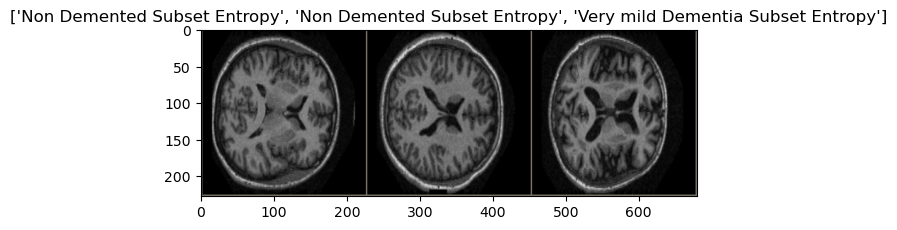

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause to update plots

# Load a batch of data and select only three images
dataiter = iter(dataloaders['train'])
images, labels = next(dataiter)

# Select the first three images and labels from the batch
images = images[:3]
labels = labels[:3]

# Make a grid from the three images
out = torchvision.utils.make_grid(images)

# Display the images
imshow(out, title=[train_dataset.classes[x] for x in labels])

## Set Up Model

### Load Model

In [5]:
# Load the pre-trained MobileNetV3 model
pretrained_weights = torchvision.models.MobileNet_V3_Small_Weights
model = torchvision.models.mobilenet_v3_small(weights=pretrained_weights).to(device)

# Freeze all the parameters for fine-tuning
for param in model.parameters():
    param.requires_grad = False

# Replace the classifier layer
model.classifier[3] = nn.Linear(model.classifier[3].in_features, 3)
model.classifier.requires_grad_ = True

/Users/dawsonhaddox/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Define Metric Functions

In [6]:
def accuracy(output, target):
    with torch.no_grad():
        pred = torch.argmax(output, dim=1)
        assert pred.shape[0] == len(target)
        correct = 0
        correct += torch.sum(pred == target).item()
    return correct / len(target)

def calculate_metrics(outputs, targets):
    _, preds = torch.max(outputs, 1)
    preds = preds.cpu().numpy()
    targets = targets.cpu().numpy()
    
    precision = precision_score(targets, preds, average='weighted', zero_division=0)
    recall = recall_score(targets, preds, average='weighted', zero_division=0)
    f1 = f1_score(targets, preds, average='weighted', zero_division=0)
    
    return precision, recall, f1

### Define Criterion, Optimizer, Scheduler

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001) # optim.(model.fc.parameters(), lr=0.001, momentum=0.9)
scheduler = None # lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

### Record Hyperparameters

In [8]:
hyperparameters = {
    "learning_rate": "0.0001",
    "optimizer": "Adam",
    "step_size": "None",
    "gamma": "None",
    "loss_function": "CrossEntropyLoss",
    "batch_size": "256",
    "num_epochs": "100",
    "patience": "5",
    "random_seed": "24",
    "Dataset": "Entropy"
}

## Train Model

### Define Training Functions

In [9]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, device, num_epochs=25, patience=5):
    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    best_model_wts = model.state_dict()
    best_acc = 0.0
    early_stopping_counter = 0
    
    # Metric history
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': [],
        'train_precision': [],
        'val_precision': [],
        'train_recall': [],
        'val_recall': [],
        'train_f1': [],
        'val_f1': []
    }

    # Open a file to write the results
    with open('training_results.txt', 'w') as f:
        f.write(str(hyperparameters) + '\n')  # Write hyperparameters at the start
        
        for epoch in range(num_epochs):
            print('Epoch {}/{}'.format(epoch + 1, num_epochs))
            print('-' * 10)
            f.write('Epoch {}/{}\n'.format(epoch + 1, num_epochs))
            f.write('-' * 10 + '\n')
            
            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0
                running_precision = 0.0
                running_recall = 0.0
                running_f1 = 0.0

                # Iterate over data.
                for inputs, labels in tqdm(dataloaders[phase], desc=phase):
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                    precision, recall, f1 = calculate_metrics(outputs, labels)
                    running_precision += precision
                    running_recall += recall
                    running_f1 += f1

                epoch_loss = running_loss / len(dataloaders[phase].dataset)
                epoch_acc = running_corrects.float() / len(dataloaders[phase].dataset)
                epoch_precision = running_precision / len(dataloaders[phase])
                epoch_recall = running_recall / len(dataloaders[phase])
                epoch_f1 = running_f1 / len(dataloaders[phase])

                # Save metrics to history
                history[f'{phase}_loss'].append(epoch_loss)
                history[f'{phase}_acc'].append(epoch_acc)
                history[f'{phase}_precision'].append(epoch_precision)
                history[f'{phase}_recall'].append(epoch_recall)
                history[f'{phase}_f1'].append(epoch_f1)

                print('{} Loss: {:.4f} Acc: {:.4f} Prec: {:.4f} Rec: {:.4f} F1: {:.4f}'.format(
                    phase, epoch_loss, epoch_acc, epoch_precision, epoch_recall, epoch_f1))
                f.write('{} Loss: {:.4f} Acc: {:.4f} Prec: {:.4f} Rec: {:.4f} F1: {:.4f}\n'.format(
                    phase, epoch_loss, epoch_acc, epoch_precision, epoch_recall, epoch_f1))

                # Check for early stopping
                if phase == 'val':
                    if epoch_acc > best_acc:
                        best_acc = epoch_acc
                        best_model_wts = model.state_dict()
                        early_stopping_counter = 0
                    else:
                        early_stopping_counter += 1
                        if early_stopping_counter >= patience:
                            print('Early stopping')
                            f.write('Early stopping\n')
                            # load best model weights
                            model.load_state_dict(best_model_wts)
                            return model, history

            # Step the scheduler
            if scheduler != None:
                scheduler.step()

            print()
            f.write('\n')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

In [10]:
def plot_metrics(history):
    """Function to plot training and validation metrics"""
    epochs = range(1, len(history['train_loss']) + 1)
    
    plt.figure(figsize=(14, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Training loss')
    plt.plot(epochs, history['val_loss'], label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Training accuracy')
    plt.plot(epochs, history['val_acc'], label='Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    
    plt.show()

In [11]:
def plot_confusion_matrix(model, dataloader, classes, device):
    """Function to plot confusion matrix"""
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

### Execute Training

In [ ]:
with torch.device(device):
    model, history = train_model(model, dataloaders, criterion, optimizer, scheduler, device=device, num_epochs=200)

Epoch 1/200
----------


train:   0%|                                             | 0/98 [00:00<?, ?it/s]

In [ ]:
plot_metrics(history)
plot_confusion_matrix(model, dataloaders['val'], ['Mild Dementia', 'Very Mild Dementia', 'Non Demented'])

## Evaluate and Save Model

In [ ]:
def evaluate_model(model, dataloader, device='cuda', save_path='model_final.pth'):
    model.eval()  # Set model to evaluation mode
    true_labels = []
    predictions = []
    
    # No gradient needed
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    # Calculate performance metrics
    precision = precision_score(true_labels, predictions, average='weighted', zero_division=0)
    recall = recall_score(true_labels, predictions, average='weighted', zero_division=0)
    f1 = f1_score(true_labels, predictions, average='weighted', zero_division=0)

    # Save model weights
    torch.save(model.state_dict(), save_path)

    # Save performance metrics to a file
    with open('test_performance.txt', 'w') as f:
        f.write(str(hyperparameters) + '\n')
        f.write(f'Precision: {precision:.4f}\n')
        f.write(f'Recall: {recall:.4f}\n')
        f.write(f'F1 Score: {f1:.4f}\n')

    # Output metrics
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')

    # Confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    plot_confusion_matrix(cm, classes=['Mild Dementia', 'Very Mild Dementia', 'Non Demented'])

def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be added by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Loop over data dimensions and create text annotations.
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in enumerate(np.meshgrid(np.arange(cm.shape[0]), np.arange(cm.shape[1]))[0]):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [ ]:
evaluate_model(model, test_data_loader)